In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy import interpolate

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
stats_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')

In [4]:
# load unconditional, BL-precip data: BL1dhist_precip_writeout
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/BLtot_precip_hist/')

data= xr.open_dataset(out_dir / 'hist1d_BL_climatology.ocean.nc')
samples = data.sum('phase').samples
prec_gpm_sum = data.sum('phase').prec_gpm_sum
pdf_uc_ocean = samples/samples.sum()
cond_prec_uc_ocean = prec_gpm_sum/samples
cond_prec_uc_ocean = cond_prec_uc_ocean.where(samples > 100)

data= xr.open_dataset(out_dir / 'hist1d_BL_climatology.land.nc')
samples = data.sum('phase').samples
prec_gpm_sum = data.sum('phase').prec_gpm_sum
pdf_uc_land = samples/samples.sum()
cond_prec_uc_land = prec_gpm_sum/samples
cond_prec_uc_land = cond_prec_uc_land.where(samples > 100)

In [5]:
%%time
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/BLtot_precip_hist/')

year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
    
    data = xr.open_dataset(out_dir / 'hist1d_BL_dtype.{}.ocean.3deg.alltracks.nc'.format(year))
    tmp = data.sum(('tracks','duration_type')).sel(bins_tot=slice(-29.75,10))
    
    if n == 0: 
        data_all_ocean = tmp
    else:
        data_all_ocean += tmp

CPU times: user 139 ms, sys: 16.3 ms, total: 156 ms
Wall time: 182 ms


In [6]:
%%time
# over land
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/BLtot_precip_hist/')

year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
    
    data = xr.open_dataset(out_dir / 'hist1d_BL_dtype.{}.land.3deg.alltracks.nc'.format(year))
    tmp = data.sum(('tracks','duration_type')).sel(bins_tot=slice(-29.75,10))
    
    if n == 0: 
        data_all_land = tmp
    else:
        data_all_land += tmp

CPU times: user 129 ms, sys: 17.4 ms, total: 146 ms
Wall time: 170 ms


#### contributions of samples from MCS phases in each BL bin 

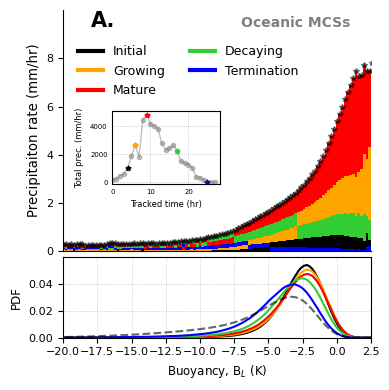

In [10]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(4,4), gridspec_kw={'height_ratios': [3, 1]})

ccolors = ['k','orange','r','limegreen','b']
samples_allphases = data_all_ocean.sel(area_type='mcs').isel(phase=slice(1,6)).samples.sum('phase')
prec_gpm_allphases = data_all_ocean.sel(area_type='mcs').isel(phase=slice(1,6)).prec_gpm_sum.sum('phase')
prec_gpm_cond = prec_gpm_allphases/samples_allphases

set_width=0.2

for bt in data_all_ocean.bins_tot.values:

    prec_contrib = []
    for phase,ccolor in zip(data_all_ocean.phase.values[1:], ccolors):

        prec_gpm_sum = data_all_ocean.sel(bins_tot=bt,area_type='mcs',phase=phase).prec_gpm_sum.values
        prec_portion = (prec_gpm_sum/prec_gpm_allphases.sel(bins_tot=bt))*prec_gpm_cond.sel(bins_tot=bt)
        prec_contrib.extend([prec_portion.values])

    y1 = np.sort(prec_contrib)[0] # rank 1st 
    y2 = np.sort(prec_contrib)[1]
    y3 = np.sort(prec_contrib)[2]
    y4 = np.sort(prec_contrib)[3]
    y5 = np.sort(prec_contrib)[4]

    c1 = ccolors[np.argsort(prec_contrib)[0]]
    c2 = ccolors[np.argsort(prec_contrib)[1]]
    c3 = ccolors[np.argsort(prec_contrib)[2]]
    c4 = ccolors[np.argsort(prec_contrib)[3]]
    c5 = ccolors[np.argsort(prec_contrib)[4]]
    
    # plot bars in stack manner
    ax1.bar(bt, y1, color=c1, width=set_width)
    ax1.bar(bt, y2, bottom=y1, color=c2, width=set_width)
    ax1.bar(bt, y3, bottom=y1+y2, color=c3, width=set_width)
    ax1.bar(bt, y4, bottom=y1+y2+y3, color=c4, width=set_width)    
    ax1.bar(bt, y5, bottom=y1+y2+y3+y4, color=c5, width=set_width)    

legend_elements = [Line2D([0], [0], color='k', lw=3, label='Initial'),
                   Line2D([0], [0], color='orange', lw=3, label='Growing'),
                   Line2D([0], [0], color='r', lw=3, label='Mature'),
                   Line2D([0], [0], color='limegreen', lw=3, label='Decaying'),
                   Line2D([0], [0], color='b', lw=3, label='Termination')]
ax1.legend(handles=legend_elements, ncols=2,bbox_to_anchor=(0.3,0.4,0.5,0.5),
           fontsize=9, frameon=False)

# add precip conditioanl 
prec_gpm_allphases = data_all_ocean.sel(area_type='mcs').isel(phase=slice(1,6)).prec_gpm_sum.sum('phase')
prec_gpm_cond = prec_gpm_allphases/samples_allphases
ax1.plot(data_all_ocean.bins_tot, prec_gpm_cond, '*',ms=4, color='k',
        alpha=0.5, zorder=3) 

ax1.set_xticklabels('')
ax1.tick_params('x', length=0, which='major')
ax1.set_ylim([0,10])
ax1.set_yticks(np.arange(0,10,2))
#ax1.set_xlabel('B$_{L}$ (K)',fontsize=10.5)
ax1.set_ylabel('Precipitaiton rate (mm/hr)',fontsize=9.5)
ax1.tick_params(labelsize=8)
#ax1.grid(lw=0.5,ls=':')
ax1.set_xlim([-20,2.5])

############## subset for showing MCS phase ###############
ins = ax1.inset_axes([0.16,0.28,0.35,0.3])
ds_track = xr.open_dataset('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/mcs_tracks_non2mcs_2001.tropics30NS.extend.nc')
ds_sub = ds_track.isel(tracks=2000)
time_phase = [ds_sub.idt_mcs_init.values, ds_sub.idt_mcs_grow.values, ds_sub.idt_mcs_mature.values,
              ds_sub.idt_mcs_decay.values, ds_sub.idt_mcs_end.values]
ds_phase = ds_sub.isel(times=time_phase)
ds_phase_rain = ds_phase.total_rain

ins.plot(range(len(ds_sub.total_rain)),ds_sub.total_rain, lw=1, marker='o',ms=3, color='grey', alpha=0.5)
for n,color in zip(np.arange(5), ['k','orange','r','limegreen','b']):
    ins.scatter(time_phase[n],ds_phase_rain[n], s=12, marker='*',color=color,zorder=2)
ins.set_xlabel('Tracked time (hr)',fontsize=6)
ins.set_ylabel('Total prec. (mm/hr)',fontsize=6)
ins.tick_params(labelsize=5, length=0)
ins.set_ylim(ymin=-100)
ins.set_xlim(xmin=0)
ins.grid(lw=0.5,ls=':')
# ins2 = ins.twinx()
# ins2.plot(range(len(ds_sub.total_rain)),ds_sub.ccs_area, lw=1, color='g')
# ins2.tick_params(labelsize=5, length=0)
# ins2.set_ylabel('Area (km$^{2}$)',fontsize=6, color='g')

################# panel 2 ###############
samples_clim = data_all_ocean.samples.sel(area_type=(['mcs','env'])).sum(('area_type','phase'))
BLpdf_clim = samples_clim/samples_clim.sum('bins_tot')
BLpdf_mcs = data_all_ocean.samples.sel(area_type='mcs')/(data_all_ocean.samples.sel(area_type='mcs')).sum('bins_tot')

# plot samples contributed by each MCS phas
for phase,ccolor in zip(data_all_ocean.phase.values[1:], ccolors):

#    samples = data_all_ocean.sel(area_type='mcs',phase=phase).samples
#    ax2.plot(data_all_ocean.bins_tot, np.log10(samples), color=ccolor, label=phase, zorder=2)
    #samples = data_all_ocean.sel(area_type='mcs',phase=phase).samples/data_all_ocean.sel(area_type='mcs').samples.sum('phase')
    ax2.plot(data_all_ocean.bins_tot, BLpdf_mcs.sel(phase=phase), color=ccolor, label=phase, zorder=2)
ax2.plot(data_all_ocean.bins_tot, BLpdf_clim, ls='--', color='k', label='Clim. (all grids)', alpha=0.6)
    
#ax2.legend(fontsize=9, loc=2)
ax2.grid(lw=0.5,ls=':')
ax2.set_xlim([-20,2.5])
ax2.set_ylim([0,0.06])
ax2.set_yticks([0,0.02,0.04])
#ax2.set_yticks([0,1])
ax2.set_ylabel('PDF',fontsize=8.5)
ax2.set_xlabel('Buoyancy, B$_{L}$ (K)',fontsize=8.5)
ax2.tick_params(labelsize=8)

# reference line indicating small sample number 
idx_100s = np.where(samples_allphases > 200)[0]
idx_s = idx_100s[0]
idx_e = idx_100s[-1]
#ax2.vlines(data_all_ocean.bins_tot[idx_s], ymin=0, ymax=6, color='grey', lw=1)
#ax2.vlines(data_all_ocean.bins_tot[idx_e], ymin=0, ymax=6, color='grey', lw=1)

plt.tight_layout(h_pad=0)
ax1.spines[['right', 'top']].set_visible(False)

# set label using text
ax1.text(x=-18, y=9.3, s='A.', fontsize=15, fontweight='bold',
        bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', pad=2.5, lw=0.5))
ax1.text(x=-7, y=9.3, s='Oceanic MCSs', fontsize=10, fontweight='bold', color='grey',
        bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', pad=2.5, lw=0.5))
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig2_condprecip_phases.ocean.ranked_PDF.png',dpi=600,
   bbox_inches='tight',transparent=False)

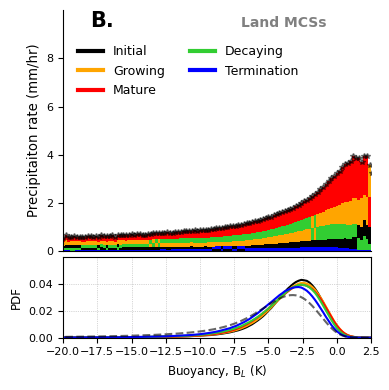

In [11]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(4,4), gridspec_kw={'height_ratios': [3, 1]})

ccolors = ['k','orange','r','limegreen','b']
samples_allphases = data_all_land.sel(area_type='mcs').isel(phase=slice(1,6)).samples.sum('phase')
prec_gpm_allphases = data_all_land.sel(area_type='mcs').isel(phase=slice(1,6)).prec_gpm_sum.sum('phase')
prec_gpm_cond = prec_gpm_allphases/samples_allphases

set_width=0.2

for bt in data_all_land.bins_tot.values:

    prec_contrib = []
    for phase,ccolor in zip(data_all_land.phase.values[1:], ccolors):

        prec_gpm_sum = data_all_land.sel(bins_tot=bt,area_type='mcs',phase=phase).prec_gpm_sum.values
        prec_portion = (prec_gpm_sum/prec_gpm_allphases.sel(bins_tot=bt))*prec_gpm_cond.sel(bins_tot=bt)
        prec_contrib.extend([prec_portion.values])

    y1 = np.sort(prec_contrib)[0] # rank 1st 
    y2 = np.sort(prec_contrib)[1]
    y3 = np.sort(prec_contrib)[2]
    y4 = np.sort(prec_contrib)[3]
    y5 = np.sort(prec_contrib)[4]

    c1 = ccolors[np.argsort(prec_contrib)[0]]
    c2 = ccolors[np.argsort(prec_contrib)[1]]
    c3 = ccolors[np.argsort(prec_contrib)[2]]
    c4 = ccolors[np.argsort(prec_contrib)[3]]
    c5 = ccolors[np.argsort(prec_contrib)[4]]
    
    # plot bars in stack manner
    ax1.bar(bt, y1, color=c1, width=set_width)
    ax1.bar(bt, y2, bottom=y1, color=c2, width=set_width)
    ax1.bar(bt, y3, bottom=y1+y2, color=c3, width=set_width)
    ax1.bar(bt, y4, bottom=y1+y2+y3, color=c4, width=set_width)    
    ax1.bar(bt, y5, bottom=y1+y2+y3+y4, color=c5, width=set_width)    

legend_elements = [Line2D([0], [0], color='k', lw=3, label='Initial'),
                   Line2D([0], [0], color='orange', lw=3, label='Growing'),
                   Line2D([0], [0], color='r', lw=3, label='Mature'),
                   Line2D([0], [0], color='limegreen', lw=3, label='Decaying'),
                   Line2D([0], [0], color='b', lw=3, label='Termination')]
ax1.legend(handles=legend_elements, ncols=2,bbox_to_anchor=(0.3,0.4,0.5,0.5),
           fontsize=9, frameon=False)

# add precip conditioanl 
prec_gpm_allphases = data_all_land.sel(area_type='mcs').isel(phase=slice(1,6)).prec_gpm_sum.sum('phase')
prec_gpm_cond = prec_gpm_allphases/samples_allphases
ax1.plot(data_all_ocean.bins_tot, prec_gpm_cond, '*',ms=4, color='k',
        alpha=0.5, zorder=3) 

ax1.set_xticklabels('')
ax1.tick_params('x', length=0, which='major')
ax1.set_ylim([0,10])
ax1.set_yticks(np.arange(0,10,2))
#ax1.set_xlabel('B$_{L}$ (K)',fontsize=10.5)
ax1.set_ylabel('Precipitaiton rate (mm/hr)',fontsize=9.5)
ax1.tick_params(labelsize=8)
#ax1.grid(lw=0.5,ls=':')
ax1.set_xlim([-20,2.5])

################# panel 2 ###############
samples_clim = data_all_land.samples.sel(area_type=(['mcs','env'])).sum(('area_type','phase'))
BLpdf_clim = samples_clim/samples_clim.sum('bins_tot')
BLpdf_mcs = data_all_land.samples.sel(area_type='mcs')/(data_all_land.samples.sel(area_type='mcs')).sum('bins_tot')

# plot samples contributed by each MCS phase
for phase,ccolor in zip(data_all_land.phase.values[1:], ccolors):
     
#    samples = data_all_ocean.sel(area_type='mcs',phase=phase).samples
#    ax2.plot(data_all_ocean.bins_tot, np.log10(samples), color=ccolor, label=phase, zorder=2)
    #samples = data_all_ocean.sel(area_type='mcs',phase=phase).samples/data_all_ocean.sel(area_type='mcs').samples.sum('phase')
    ax2.plot(data_all_land.bins_tot, BLpdf_mcs.sel(phase=phase), color=ccolor, label=phase, zorder=2)
ax2.plot(data_all_land.bins_tot, BLpdf_clim, ls='--', color='k', label='Clim. (all grids)', alpha=0.6)
    
#ax2.legend(fontsize=9, loc=2)
ax2.grid(lw=0.5,ls=':')
ax2.set_xlim([-20,2.5])
ax2.set_ylim([0,0.06])
ax2.set_yticks([0,0.02,0.04])
#ax2.set_yticks([0,1])
ax2.set_ylabel('PDF',fontsize=8.5)
ax2.set_xlabel('Buoyancy, B$_{L}$ (K)',fontsize=8.5)
ax2.tick_params(labelsize=8)

# reference line indicating small sample number 
idx_100s = np.where(samples_allphases > 200)[0]
idx_s = idx_100s[0]
idx_e = idx_100s[-1]
#ax2.vlines(data_all_ocean.bins_tot[idx_s], ymin=0, ymax=6, color='grey', lw=1)
#ax2.vlines(data_all_ocean.bins_tot[idx_e], ymin=0, ymax=6, color='grey', lw=1)

plt.tight_layout(h_pad=0)
ax1.spines[['right', 'top']].set_visible(False)

# set label using text
ax1.text(x=-18, y=9.3, s='B.', fontsize=15, fontweight='bold',
        bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', pad=2.5, lw=0.5))
ax1.text(x=-7, y=9.3, s='Land MCSs', fontsize=10, fontweight='bold', color='grey',
        bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', pad=2.5, lw=0.5))
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig2_condprecip_phases.land.ranked_PDF.png',dpi=600,
    bbox_inches='tight',transparent=False)